In [2]:
from pyspark.sql import SparkSession

# Initialize a Spark session
spark = SparkSession.builder \
    .appName("ETL Process") \
    .getOrCreate()

print("Spark Session Initialized!")

Spark Session Initialized!


In [36]:
from pyspark.sql.functions import lit

# First Step of ETL: Extract
file_paths = [
    "2015.csv",
    "2016.csv",
    "2017.csv",
    "2018.csv",
    "2019.csv",
]

# Read each CSV file into a DataFrame
years = [2015, 2016, 2017, 2018, 2019]

df_list = []
for i, file_path in enumerate(file_paths):
    df = spark.read.csv(file_path, header=True, inferSchema=True)
    df = df.withColumn("Year", lit(years[i]))
    df_list.append(df)

df_list[0].show(5),
df_list[1].show(5),
df_list[2].show(5),
df_list[3].show(5),
df_list[4].show(5),

+-----------+--------------+--------------+---------------+--------------+------------------------+-------+------------------------+-------+-----------------------------+----------+-----------------+----+
|    Country|        Region|Happiness Rank|Happiness Score|Standard Error|Economy (GDP per Capita)| Family|Health (Life Expectancy)|Freedom|Trust (Government Corruption)|Generosity|Dystopia Residual|Year|
+-----------+--------------+--------------+---------------+--------------+------------------------+-------+------------------------+-------+-----------------------------+----------+-----------------+----+
|Switzerland|Western Europe|             1|          7.587|       0.03411|                 1.39651|1.34951|                 0.94143|0.66557|                      0.41978|   0.29678|          2.51738|2015|
|    Iceland|Western Europe|             2|          7.561|       0.04884|                 1.30232|1.40223|                 0.94784|0.62877|                      0.14145|    0.4363

(None,)

Data here has problem not all years has same col num

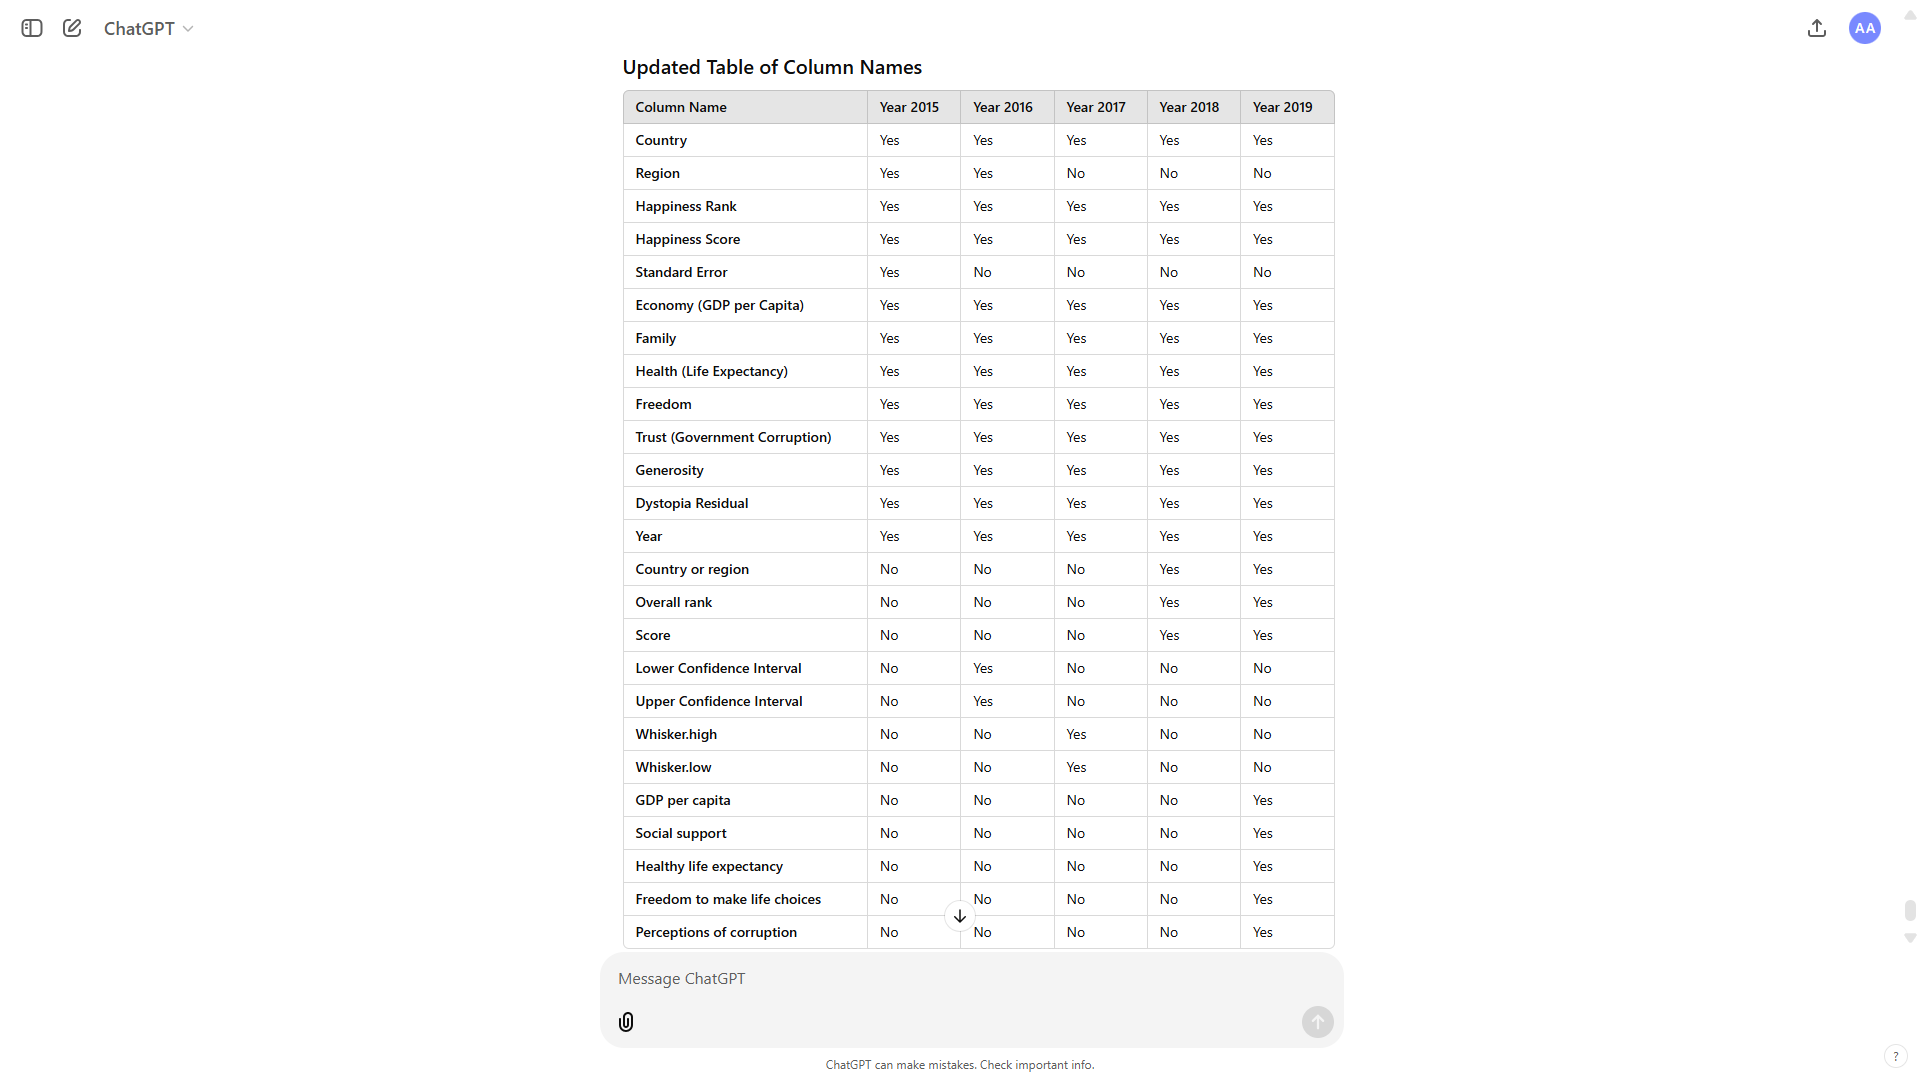

In [1]:
# note here there are cols that aren't common in all
# also note the rank is based on happiness score, so i can del any others as i want cause it is for you in making model to make prediction of when some row in like (Whisker.high)
# col has value it affected some how by the happiness score etc.

In [ ]:
# Second Step of ETL: Transform
columns= ['Region','Standard Error','Lower Confidence Interval','Upper Confidence Interval','Perceptions of corruption',
                             'Freedom to make life choices','Healthy life expectancy','Social support','Whisker.low',
                             'Whisker.high',]
def drop_columns(df,cols):
  return df.drop(*[col for col in cols if col in df.columns])

cleaned_list = [drop_columns(df,columns) for df in df_list]
cleaned_list[0],
cleaned_list[1],
cleaned_list[2],
cleaned_list[3],
cleaned_list[4]

DataFrame[Overall rank: int, Country or region: string, Score: double, GDP per capita: double, Generosity: double, Year: int]

In [31]:
# from above we can see that 2018,2019 still has less data and if i delete them then the dataset will be smaller so i am gonna remove the 2 lists for group safety (:

In [42]:
# pop last 2, don't run again
# cleaned_list.pop()
# cleaned_list.pop()
cleaned_list

[DataFrame[Country: string, Happiness Rank: int, Happiness Score: double, Economy (GDP per Capita): double, Family: double, Health (Life Expectancy): double, Freedom: double, Trust (Government Corruption): double, Generosity: double, Dystopia Residual: double, Year: int],
 DataFrame[Country: string, Happiness Rank: int, Happiness Score: double, Economy (GDP per Capita): double, Family: double, Health (Life Expectancy): double, Freedom: double, Trust (Government Corruption): double, Generosity: double, Dystopia Residual: double, Year: int],
 DataFrame[Country: string, Happiness.Rank: int, Happiness.Score: double, Economy..GDP.per.Capita.: double, Family: double, Health..Life.Expectancy.: double, Freedom: double, Generosity: double, Trust..Government.Corruption.: double, Dystopia.Residual: double, Year: int]]

In [43]:
# now i need to rename cols to be the same
# cleaned_list[1]=cle
common_columns_mapping = {
    "Country":"Country",
    "Rank": ["Happiness Rank", "Happiness.Rank",],
    "Score": ["Happiness Score", "Happiness.Score",],
    "Economy": ["Economy (GDP per Capita)", "Economy..GDP.per.Capita."],
    "Family": ["Family"],
    "Health": ["Health (Life Expectancy)", "Health..Life.Expectancy."],
    "Freedom": ["Freedom"],
    "Trust": ["Trust (Government Corruption)", "Trust..Government.Corruption."],
    "Generosity": ["Generosity"],
    "Dystopia Residual": ["Dystopia Residual", "Dystopia.Residual"],
    "Year": ["Year"]
}

def rename_columns(df, column_mapping):
  for common_name, aliases in column_mapping.items():
    for alias in aliases:
      if alias in df.columns:
        df = df.withColumnRenamed(alias, common_name)
        break
  return df

df_list_renamed = []
for df in cleaned_list:
  df_renamed = rename_columns(df, common_columns_mapping)
  df_list_renamed.append(df_renamed)

df_list_renamed

[DataFrame[Country: string, Rank: int, Score: double, Economy: double, Family: double, Health: double, Freedom: double, Trust: double, Generosity: double, Dystopia Residual: double, Year: int],
 DataFrame[Country: string, Rank: int, Score: double, Economy: double, Family: double, Health: double, Freedom: double, Trust: double, Generosity: double, Dystopia Residual: double, Year: int],
 DataFrame[Country: string, Rank: int, Score: double, Economy: double, Family: double, Health: double, Freedom: double, Generosity: double, Trust: double, Dystopia Residual: double, Year: int]]

In [44]:
# now as all cols are same we can now merge them

In [56]:
final_df = df_list_renamed[0]
for df in df_list_renamed[1:]:
  final_df = final_df.unionAll(df)

final_df = final_df.coalesce(1)
final_df.show()

+--------------------+----+-----+-------+-------+-------+-------+-------+----------+-----------------+----+
|             Country|Rank|Score|Economy| Family| Health|Freedom|  Trust|Generosity|Dystopia Residual|Year|
+--------------------+----+-----+-------+-------+-------+-------+-------+----------+-----------------+----+
|         Switzerland|   1|7.587|1.39651|1.34951|0.94143|0.66557|0.41978|   0.29678|          2.51738|2015|
|             Iceland|   2|7.561|1.30232|1.40223|0.94784|0.62877|0.14145|    0.4363|          2.70201|2015|
|             Denmark|   3|7.527|1.32548|1.36058|0.87464|0.64938|0.48357|   0.34139|          2.49204|2015|
|              Norway|   4|7.522|  1.459|1.33095|0.88521|0.66973|0.36503|   0.34699|          2.46531|2015|
|              Canada|   5|7.427|1.32629|1.32261|0.90563|0.63297|0.32957|   0.45811|          2.45176|2015|
|             Finland|   6|7.406|1.29025|1.31826|0.88911|0.64169|0.41372|   0.23351|          2.61955|2015|
|         Netherlands|   7|7

In [51]:
# now we done with extract

In [58]:
# Third Step in ETL: Load
# save PySpark DataFrame to .CSV file

output_path = "cleaned_data"
final_df.write.mode("overwrite").option("header","true").csv(output_path)
print("Data Successfully Saved")

Data Successfully Saved
